In [83]:
#import some common things
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [84]:
# Declare relative directory paths and what they represent
gl_rel_dir = "../python_scraper/geospatialData/"
geospatial_rel_files = {"FA16" : gl_rel_dir+"FA16-geospatial.csv",
                                        "FA17" : gl_rel_dir+"FA17-geospatial.csv",
                                        "SP17" : gl_rel_dir+"SP17-geospatial.csv",
                                        "WI17" : gl_rel_dir+"WI17-geospatial.csv"}
geospatial_sum_files = {}

MIN_STU_AVG = 30        # defines minimum average allowable for classrooms to be considered
MIN_CLASS_SIZE = 1   # without this many students minimum, it's not technically a class
IGNORE_LIST = ["RECGM", "NIERM", "MCC"]           # ignore things outside of main UCSD

In [85]:
# Now concatenate them all in a meaningful way
quarters_pd = pd.concat([pd.read_csv(loc) for loc in geospatial_rel_files.values()], 
                                keys = geospatial_rel_files.keys())

# classes with less the MIN students will not be considered
quarters_pd.drop(quarters_pd[quarters_pd.students_number < MIN_CLASS_SIZE].index, inplace=True)

# group the data by building
quarters_grouped = quarters_pd.groupby("building_tag")
quarters_pd

building_tag  longitude    latitude day  hour  students_number
FA16 0            YORK  32.874554 -117.240005   M    12              113
     2            SERF  32.879664 -117.235105  Th    13                4
     3           VAUGN  32.865324 -117.252961   F    14                9
     4            BONN  32.875415 -117.240332  Th    11               19
     5           CENTR  32.877773 -117.237262   W    12             1405
     6             SME  32.879890 -117.233139   M    14               46
     7             WLH  32.880558 -117.234319  Tu    19              331
     8           VAUGN  32.865324 -117.252961  Tu     9               10
     9            EBU2  32.881243 -117.233615   W    17               24
     10           CPMC  32.877962 -117.234429  Tu     9              157
     11            MCC  32.881560 -117.240280   W    16               70
     12           ECON  32.875323 -117.235500   M    15               24
     13            APM  32.879039 -117.241028   M    13               44
     14          OTRSN  32.886620 -117.241109   M    14               32
     15          CENTR  32.877773 -117.237262  Tu    17              890
     16           CPMC  32.877962 -117.234429  Th     9              157
     17           CPMC  32.877962 -117.234429  Th    13               10
     18          TM102  32.881485 -117.239680  Tu    13               17
     19          CENTR  32.877773 -117.237262  Tu     9             1523
     20            RBC  32.884341 -117.240977  Tu    14               14
     21            NSB  32.875274 -117.242808   M    20               26
     22            WLH  32.880558 -117.234319   F    16              724
     23          SOLIS  32.880931 -117.239798  Tu    12              458
     25            HSS  32.878391 -117.241665  Th    10              352
     26             GH  32.873717 -117.240975   F    17                2
     27          PACIF  32.876030 -117.242393   W     9               41
     28            LIT  32.880495 -117.233850   F    13               34
     29          CENTR  32.877773 -117.237262   M    13             1164
     30          SOLIS  32.880931 -117.239798  Th    12              458
     31            APM  32.879039 -117.241028  Tu    12              270
...                ...        ...         ...  ..   ...              ...
SP17 2085        PETER  32.880013 -117.240351   M    12              721
     2086        MYR-A  32.875268 -117.240194  Th    14               88
     2087          SME  32.879890 -117.233139   W     7               12
     2088        MAYER  32.875322 -117.240190   W    17               22
     2089          NSB  32.875274 -117.242808  Tu    14               38
     2090        PETER  32.880013 -117.240351  Th    11              717
     2091        MYR-A  32.875268 -117.240194  Tu    10               45
     2092         CPMC  32.877962 -117.234429   M    14               12
     2093        SEQUO  32.882173 -117.240561   M    20               64
     2094         EBU1  32.881659 -117.235623   F    10               42
     2095         EBU2  32.881243 -117.233615   M    11               68
     2096        SOLIS  32.880931 -117.239798   W    17              375
     2097          BSB  32.875597 -117.236066  Tu    10               65
     2098          SME  32.879890 -117.233139  Tu    18               61
     2099          MCC  32.881560 -117.240280  Th    12               50
     2100        EBU3B  32.881835 -117.233523  Tu    13               65
     2101          VAF  32.879180 -117.234138  Th    17               22
     2103        MNDLR  32.879312 -117.242139  Tu    16               11
     2104        NIERN  32.868487 -117.251196   M    11                8
     2105          WLH  32.880558 -117.234319  Th    10              768
     2106         PFBH  32.881568 -117.234351   F     9               19
     2107          WFH  32.886956 -117.241839   W    11              132
     2109        MCGIL  32.879049 -117.242043  Tu    11             

In [105]:
# now remove the buildings whose average number of students is too low (outliers)
dat_tupled = []
z_scores = []
for groups in quarters_grouped.groups:
    curr_avg = quarters_grouped.get_group(groups).students_number.mean()
    if curr_avg >= MIN_STU_AVG and groups not in IGNORE_LIST:
        curr_std = quarters_grouped.get_group(groups).students_number.std()
        dat = quarters_grouped.get_group(groups).students_number
        dat_tupled.append((groups, curr_avg, curr_std, dat))
        z_scores=(quarters_grouped.get_group(groups).students_number-curr_avg)/curr_std
        print '{:12}'.format(groups), "\t\tZSCORE RANGE= [", min(z_scores),", ", max(z_scores), "]"
        
# sort resultant data
dat_tupled = sorted(dat_tupled, key=lambda x:x[1], reverse=True)
        
# unzips tuples made above
labels, averages, stdevs, dats= zip(*dat_tupled)

MCGIL        		ZSCORE RANGE= [ -1.70928487601 ,  2.60380447707 ]
LIT          		ZSCORE RANGE= [ -1.42514049486 ,  3.19905452133 ]
LEDDN        		ZSCORE RANGE= [ -3.81938315294 ,  1.38644996674 ]
WFH          		ZSCORE RANGE= [ -1.84833157964 ,  2.23668888907 ]
SME          		ZSCORE RANGE= [ -1.19746154789 ,  3.22849893353 ]
OTRSN        		ZSCORE RANGE= [ -2.13800522072 ,  2.89339833879 ]
SEQUO        		ZSCORE RANGE= [ -2.12903868871 ,  1.97142124411 ]
PCYNH        		ZSCORE RANGE= [ -2.37959548003 ,  1.81076346972 ]
CENTR        		ZSCORE RANGE= [ -2.36653211067 ,  1.6664542766 ]
NSB          		ZSCORE RANGE= [ -1.44954992033 ,  2.09860212346 ]
HSS          		ZSCORE RANGE= [ -2.53875917935 ,  1.91593820318 ]
PETER        		ZSCORE RANGE= [ -2.55341674259 ,  1.67056278818 ]
BSB          		ZSCORE RANGE= [ -1.79466696766 ,  0.909313904172 ]
ASANT        		ZSCORE RANGE= [ -1.7287304356 ,  1.8158272071 ]
ECKRT        		ZSCORE RANGE= [ -1.44571973445 ,  1.75375660969 ]
CSB          		ZSCORE RANGE

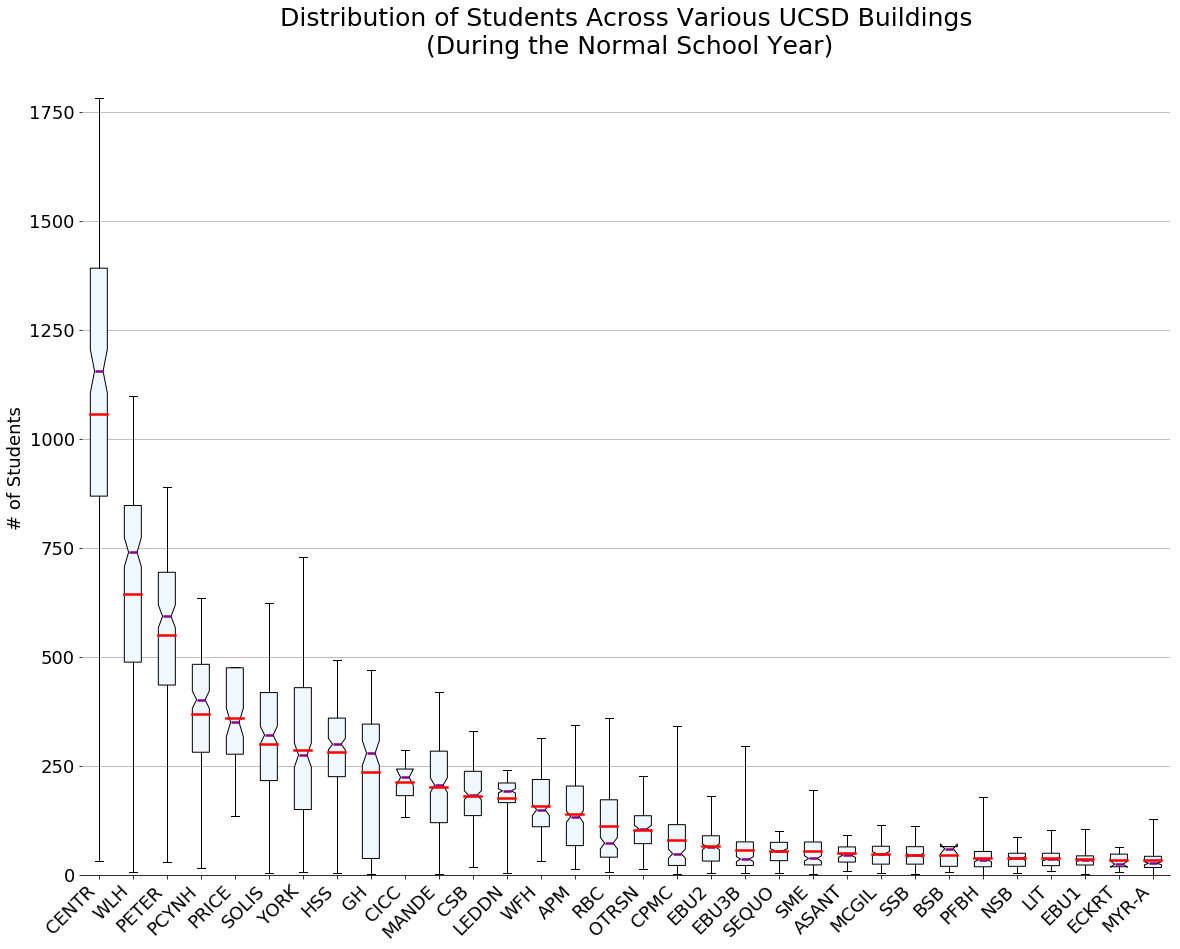

In [106]:
# customization elements
medianprops = dict(linestyle='-.', linewidth=2.5, color='darkmagenta')
meanlineprops = dict(linestyle='-', linewidth=2.5, color='red')

# Now plot using a common box plot with soft colors
fig1, ax1 = plt.subplots(figsize=(19.5,15))
bplot = ax1.boxplot(dats, vert = True, patch_artist = True, showmeans=True, notch=True,
                    meanline=True, medianprops=medianprops, meanprops=meanlineprops, whis='range')
for bplots in bplot:
    for patch in bplot['boxes']:
        patch.set_facecolor('aliceblue')
    
# sets custom labels and titles and such
ax1.set_xticklabels(labels, rotation=45, ha='right')
ax1.set_title("Distribution of Students Across Various UCSD Buildings\n (During the Normal School Year)", fontsize = 25)
ax1.yaxis.grid(True)
ax1.set_ylabel("# of Students")

# resizes the text in the display
for item in ([ax1.xaxis.label, ax1.yaxis.label] + ax1.get_xticklabels() + ax1.get_yticklabels()):
    item.set_fontsize(18)

# remove spines and set limit
ax1.spines["top"].set_visible(False)   
ax1.spines["right"].set_visible(False)
ax1.spines["left"].set_visible(False)
ax1.set_ylim(0, )
fig1.show()